# Response of Tropical Cyclones to Volcanic Eruptions

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [31]:
%run -im pythonstartup

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd

import geoxarray
from geoplots import mapplot, yticks2lat

from itertools import product
from cftime import DatetimeJulian
import xarray as xr
import cartopy.crs as ccrs

from mystats import p2t

**2019-04-22T11:27:47.517969**
>>> Importing Python 3.7.2 packages...
[OK]: import sys, os, os.path, datetime, glob
[OK]: import numpy as np-1.16.2
[OK]: import matplotlib as mpl-3.0.3; backend: nbAgg
[OK]: #---import matplotlib.pyplot as plt
[OK]: #---from pylab import *
[OK]: import xarray as xr-0.12.0
[OK]: #---import netCDF4
[OK]: #---import dask
[OK]: #---import bottleneck
[OK]: import pandas as pd-0.24.2
[OK]: from mpl_toolkits.basemap import Basemap
      PROJ_LIB = /tigress/wenchang/miniconda3p7/share/proj
>>>Import packages from Wenchang Yang (wython)...
[OK]: import geoplots as gt
[OK]: from geoplots import geoplot, fxyplot, mapplot, xticksyear
[OK]: import geoxarray
[OK]: import filter
[OK]: import xlearn
[OK]: import mysignal as sig
**Done**


In [32]:
import regionmask

In [34]:
def lon_shift(da):
    '''shift central longitude'''
    return da.roll(lon=da.lon.size//2).pipe(lambda x: x.assign_coords(lon=x.lon-(x.lon>180)*360))

In [33]:
def axscale(ax=None, right=0, left=0, up=0, down=0):
    '''scale the axes by the four sides'''
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    w_new = w*(1 + right + left)
    h_new = h*(1 + up + down)
    x0_new = x0 - w*left
    y0_new = y0 - h*down
    ax.set_position([x0_new, y0_new, w_new, h_new])
    return ax

In [35]:
def get_tc_density(ifile, mon_start=None, mon_end=None):
    '''obtain TC # within the specified period (mon_start, mon_end) given the tracks file'''
#     ifile = None
#     ifile = '/tigress/wenchang/MODEL_OUT/CTL1860_noleap_tigercpu_intelmpi_18_576PE/analysis_lmh/cyclones_gav_ro110_1C_330k/atmos_11_11/Harris.TC/lmh_TCtrack_ts_4x.dat.warm.h29_25.TS.world.20110101-20120101.txt'

#     names = None
    names = ('time', 'lon', 'lat', 'slp', 'maxSpeed', 'tm')

#     mon_start = None
#     mon_end = 6

    lon_edges = None
    if lon_edges is None:
        lon_edges = np.arange(0,361)
    lon_centers = ( lon_edges[0:-1] + lon_edges[1:] )/2
    lon_range = (lon_edges[0], lon_edges[-1])

    lat_edges = None
    if lat_edges is None:
        lat_edges = np.arange(-60,61)
    lat_centers = ( lat_edges[0:-1] + lat_edges[1:] )/2
    lat_range = (lat_edges[0], lat_edges[-1])


    # use pandas to read the txt file
    df = pd.read_csv(ifile, sep='\s+', names=names)
    # remove lines of track headers, i.e. lines with '+++'
    L = ['+++' not in t for t in df.time]
    df = df[L]

    # select date range if specified
    t0 = df.time.iloc[0]
    year = t0[0:4]
    if mon_start is not None:
        t_start = f'{year}{mon_start:02d}0100'
        df = df[df.time>t_start]
    if mon_end is not None:
        t_end = f'{year}{mon_end:02d}0100'
        df = df[df.time<=t_end]

    # use numpy.histgram2d to count TC #
    H, _dump1, _dump2 = np.histogram2d(df.lat, df.lon, 
                                       bins=[lat_edges, lon_edges],
                                       range=[lat_range, lon_range]
                                      ) 
    # wrap to xarray.DataArray
    H = xr.DataArray(H, dims=['lat', 'lon'], coords=[lat_centers, lon_centers])
    
    return H

def lowpass_tc(H):
    '''rolling sum over lat and lon'''
    return H.rolling(lon=10, center=True, min_periods=1).sum() \
            .rolling(lat=10, center=True, min_periods=1).sum()

def tcplot(H, tag=None, **kws):
    cmap = kws.pop('cmap', 'OrRd')
    if tag is None:
        tag = ''
    plt.figure(figsize=(8,2.5))
#     H = H/4 # 4xdaily
    H.pipe(lowpass_tc).rename(f'TC days per year') \
        .geo.cartoplot(proj='cyl', proj_kws={'central_longitude': 180}, cmap=cmap, **kws)
    plt.title(tag)

    plt.tight_layout()

# control runs
def ctl_tc_density_make():
    time_new = xr.cftime_range('0001-01', '0034-12', freq='MS', calendar='noleap')
    years = np.arange(11, 45)
    month_starts = [None,] + list(range(2, 13))
    month_ends = month_starts[1:] + [None,]
    das = []
    print('years')
    for year in years:
        print(year, end='; ')
        for mon_start,mon_end in zip(month_starts, month_ends):
            ifile = glob.glob(f'/tigress/wenchang/MODEL_OUT/CTL1860_noleap_tigercpu_intelmpi_18_576PE/analysis_lmh/cyclones_gav_ro110_1C_330k/atmos_{year}_{year}/Harris.TC/lmh_TCtrack_ts_4x.dat.warm.h29_25.TS.world.*-*.txt')[0]
            das.append(get_tc_density(ifile, mon_start=mon_start, mon_end=mon_end))
    print()
    da = xr.concat(das, dim=pd.Index(time_new, name='time'))

    # ctl -> ctl_ens
    ens = np.arange(1, 31)
    time_new = xr.cftime_range('0001-01', '0005-12', freq='MS', calendar='noleap')
    das = []
    print('ens')
    for en in ens:
        print(en, end='; ')
        year = en
        tspan = slice(f'{year:04d}-01', f'{year+4:04d}-12')
        das.append(da.sel(time=tspan).assign_coords(time=time_new))
    da = xr.concat(das, dim=pd.Index(ens, name='en'))
    print()
    
    return da

# Volcanic runs
def volc_tc_density_make(volc, year_erupt):
    '''construct tc density from the volc experiments'''
#     volc = 'Agung'
#     year_erupt = 1963
    time_new = xr.cftime_range(f'{year_erupt}-01', periods=12*5, freq='MS', calendar='noleap')
    ens = np.arange(1, 31)
    years = time_new.year[0::12]
    month_starts = [None,] + list(range(2, 13))
    month_ends = month_starts[1:] + [None,]
    das_ens = []
    print('ens:')
    for en in ens:
        print(en, end='; ')
        das = []
        for year in years:
            for mon_start,mon_end in zip(month_starts, month_ends):
                ifile = glob.glob(f'/tigress/wenchang/MODEL_OUT/{volc}_PI_ens_noleap/en{en:02d}/analysis_lmh/cyclones_gav_ro110_1C_330k/atmos_{year}_{year}/Harris.TC/lmh_TCtrack_ts_4x.dat.warm.h29_25.TS.world.*-*.txt')[0]
                das.append(get_tc_density(ifile, mon_start=mon_start, mon_end=mon_end))
        da = xr.concat(das, dim=pd.Index(time_new, name='time'))
        das_ens.append(da)
    da = xr.concat(das_ens, dim=pd.Index(ens, name='en'))
    print()
    
    return da

In [36]:
# data ctl_ens
ctl_ens = ctl_tc_density_make()

years
11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 
ens
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 


In [96]:
# save to ncfile
ofile = 'data/TC_Hist2D_ctl_ens.nc'
if not os.path.exists(ofile):
    ctl_ens.to_dataset(name='TC_Hist2D').to_netcdf(ofile)

In [37]:
# ctl ens-mean
ctl_emean = ctl_ens.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4).pipe(lowpass_tc)
# ctl zonal-mean
ctl_zmean = ctl_emean.mean('lon')

<IPython.core.display.Javascript object>


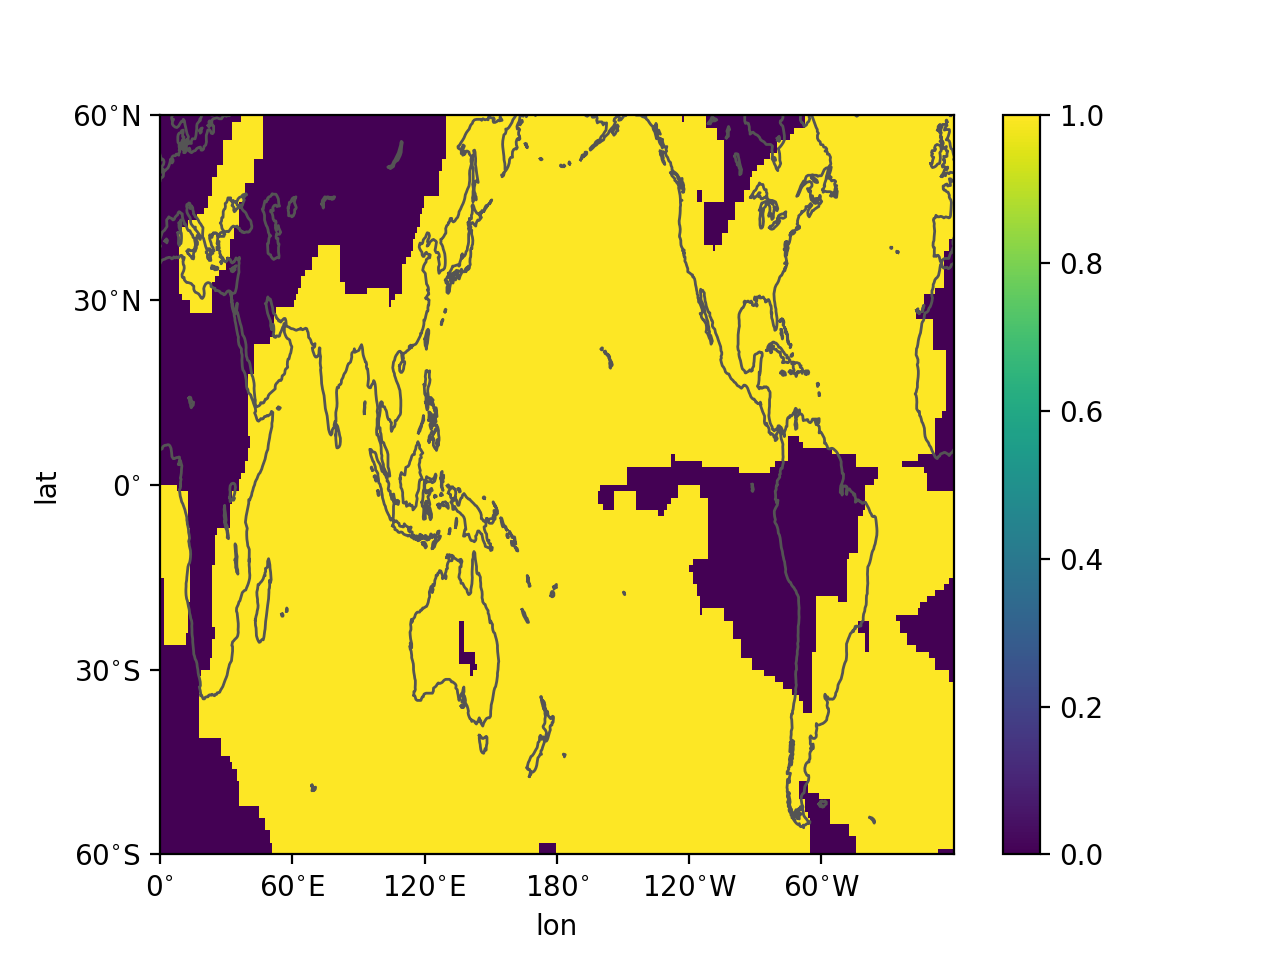

<xarray.DataArray (lat: 120, lon: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 56.5 57.5 58.5 59.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [38]:
tcmask = ctl_ens.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lambda x: x.where(x>0)).pipe(lowpass_tc) > 0
tcmask.plot()
mapplot()
tcmask

In [39]:
# data volc
if 'dvs' not in globals():
    dvs = dict()
volcs = [('Pinatubo', 1991), ('Agung', 1963), ('StMaria', 1902)]
for volc,year_erupt in volcs:
    print(volc, year_erupt)
    dvs[volc] = volc_tc_density_make(volc, year_erupt)

Pinatubo 1991
ens:
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 
Agung 1963
ens:
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 
StMaria 1902
ens:
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 


In [95]:
# save to nc file
for volc in ('Pinatubo', 'Agung', 'StMaria'):
    ofile = f'data/TC_Hist2D_{volc}.nc'
    if not os.path.exists(ofile):
        print('Saving', volc)
        dvs[volc].to_dataset(name=f'TC_Hist2D_{volc}').to_netcdf(ofile)

## figs

### control climatology

<IPython.core.display.Javascript object>


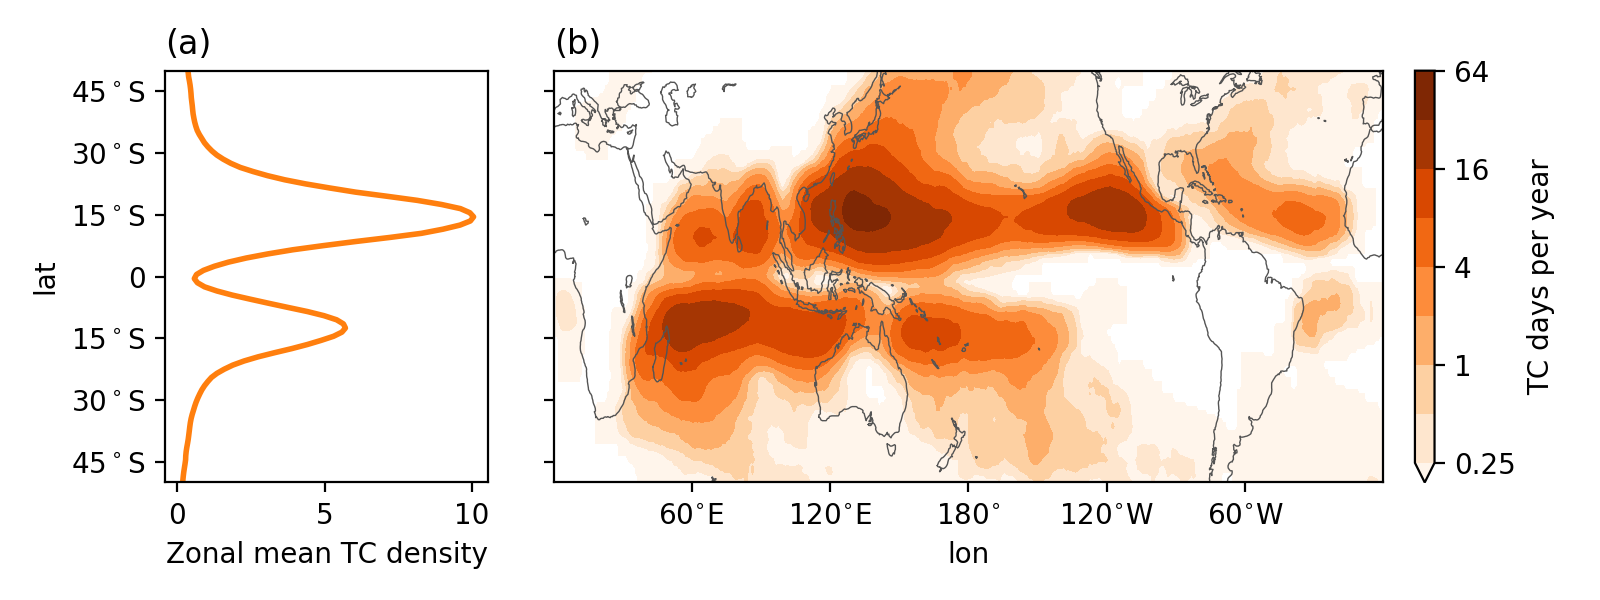

In [41]:
# TC density in control run
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
da = ctl_ens
levels = 2**np.arange(-2, 7).astype('float')
cbar_kws = dict(ticks=[0.25, 1, 4, 16, 64], format='%.2g')

ax = axes[0]
ctl_zmean.plot(ax=ax, y='lat', color='C1')
plt.autoscale()
ax.set_ylabel('lat')
ax.set_xlabel('Zonal mean TC density')
ax.set_title('(a)', loc='left')

ax = axes[1]

ctl_emean.rename('TC days per year') \
    .where(tcmask).plot.contourf(ax=ax, robust=True, levels=levels, cbar_kwargs=cbar_kws, cmap='Oranges')
mapplot(coastlines_width=1/2)
plt.ylim(-50, 50)
plt.ylabel('')
ax.set_yticks(range(-45, 46, 15))
ax.set_yticklabels([f'{-n}$^\circ$S' for n in range(-45,0,15)]
                  + ['0']
                  + [f'{n}$^\circ$S' for n in range(15, 46, 15)])
ax.set_title('(b)', loc='left')



plt.tight_layout()
axscale(axes[0], right=-0.5)
axscale(axes[1], left=0.6)

plt.savefig('figs/fig_tc_ctl.pdf')

### TC responses in volc experiments

<IPython.core.display.Javascript object>


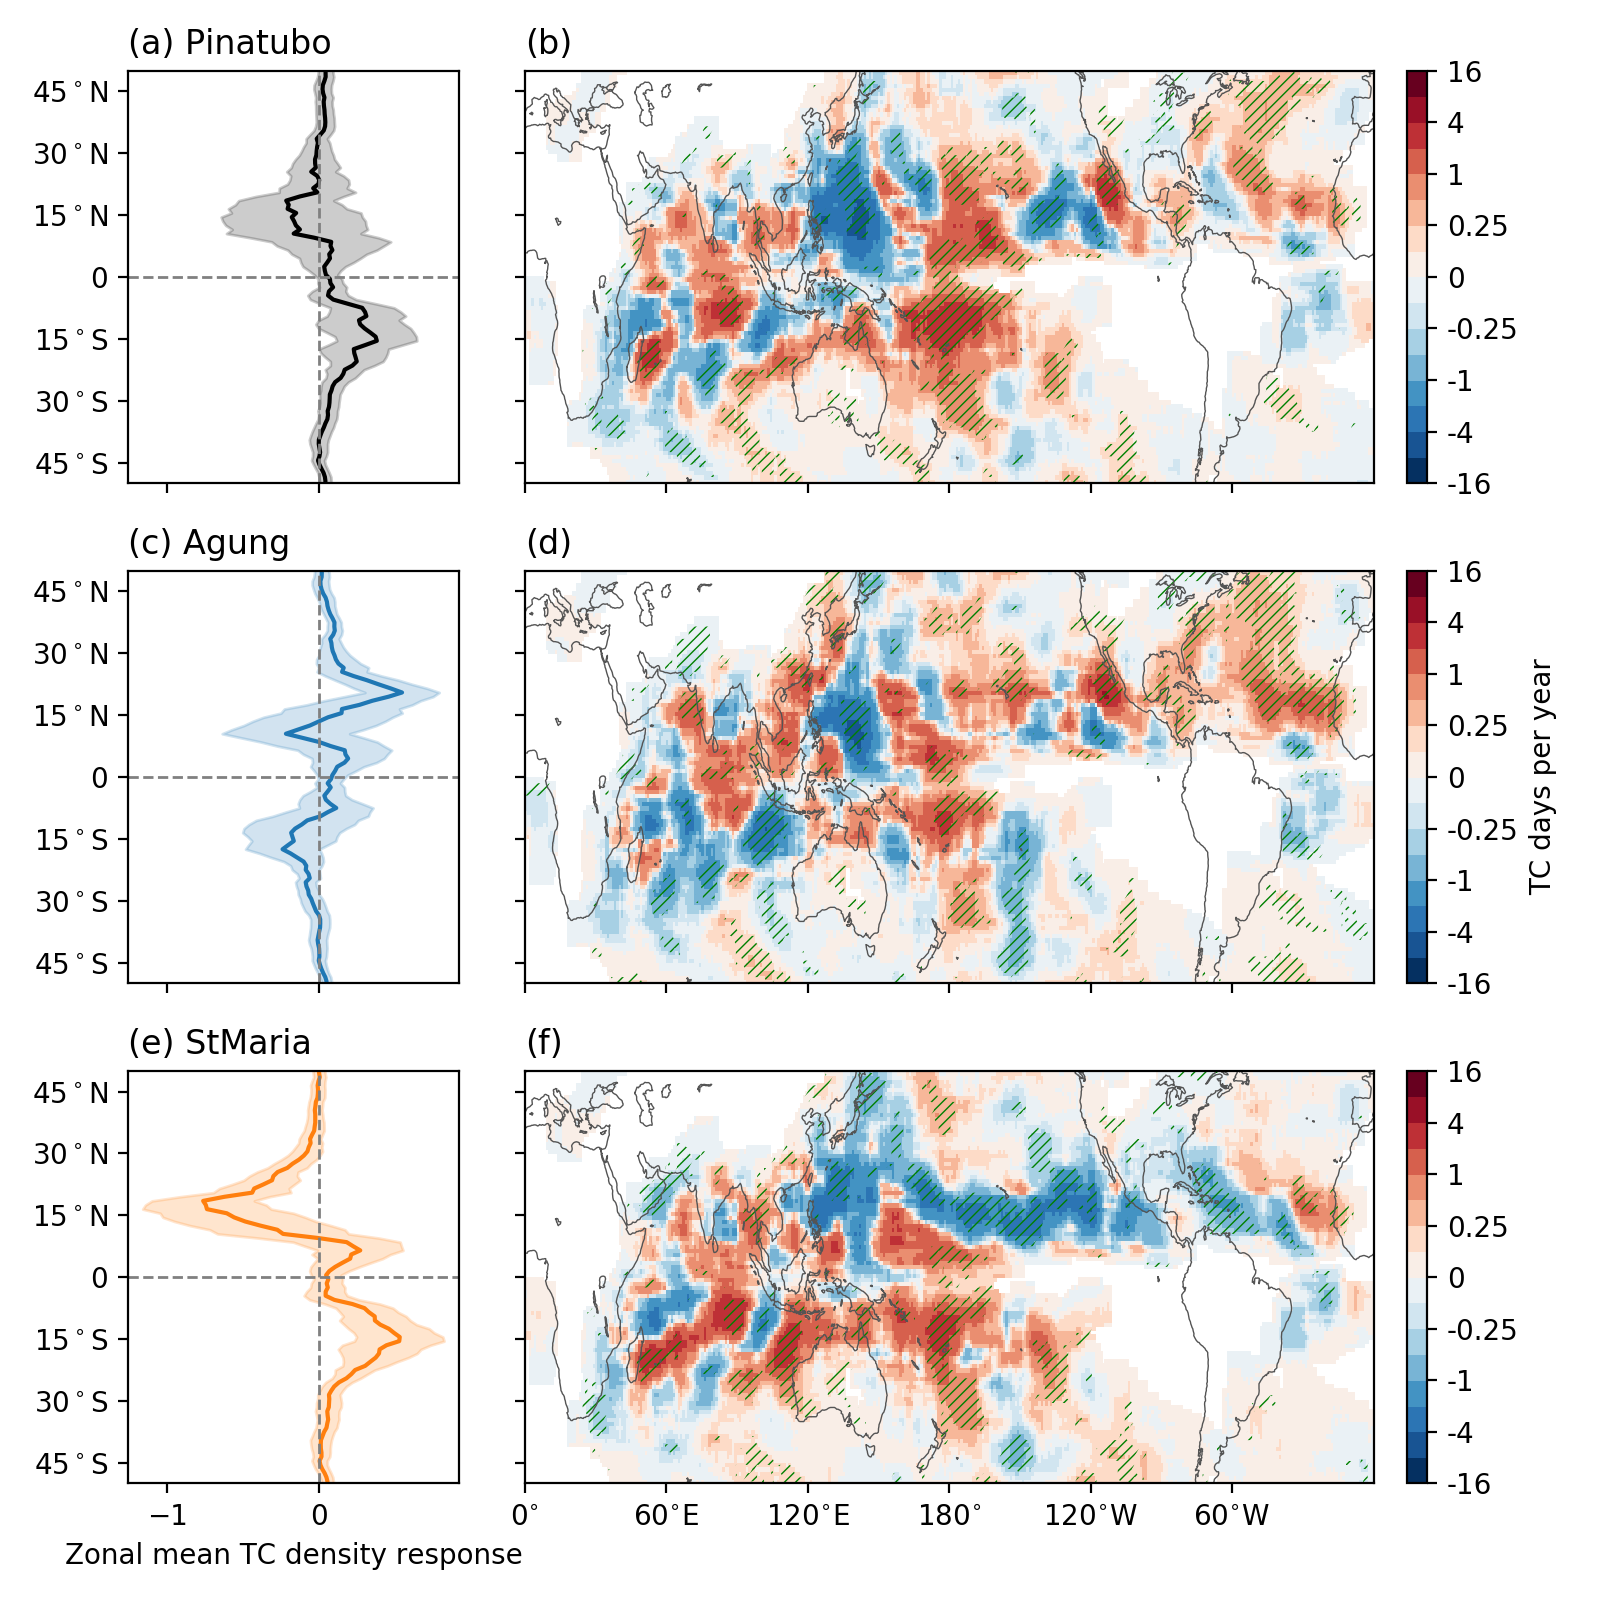

/tigress/wenchang/miniconda3p7/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/tigress/wenchang/miniconda3p7/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/tigress/wenchang/miniconda3p7/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [40]:
# fig revision_1 spread 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 2**np.arange(-3, 4.1)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = (-16, -4, -1, -0.25, 0, 0.25, 1, 4, 16)
cbar_format = '%.2g'
alpha=0.2
hatches = ['//////']

ax = axes[0, 0]
volc_name, tag, mon_start = 'Pinatubo', 'Pinatubo', 6
color = 'k'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)
ts = ts.mean('en')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color=color, alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag, mon_start = 'Agung', 'Agung', 3
color = 'C0'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)
ts = ts.mean('en')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[2, 0]
volc_name, tag, mon_start = 'StMaria', 'StMaria', 10
color = 'C1'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)
ts = ts.mean('en')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C1', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('Zonal mean TC density response')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[0, 1]
volc_name, mon_start = 'Pinatubo', 6
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')
# expand_ax(ax)

ax = axes[1, 1]
volc_name, mon_start = 'Agung', 3
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).rename('TC days per year').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')
# expand_ax(ax)



ax = axes[2, 1]
plt.sca(ax)
volc_name, mon_start = 'StMaria', 10
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45$^\circ$S', '30$^\circ$S', '15$^\circ$S', '0', '15$^\circ$N', '30$^\circ$N', '45$^\circ$N'])
plt.title('(f)', loc='left')
# yticks2lat(np.arange(-45,46,15))
# expand_ax(ax)



plt.tight_layout()
for ax in axes[:, 0]:
    axscale(ax, right=-0.5)
for ax in axes[:, 1]:
    axscale(ax, left=0.6)

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


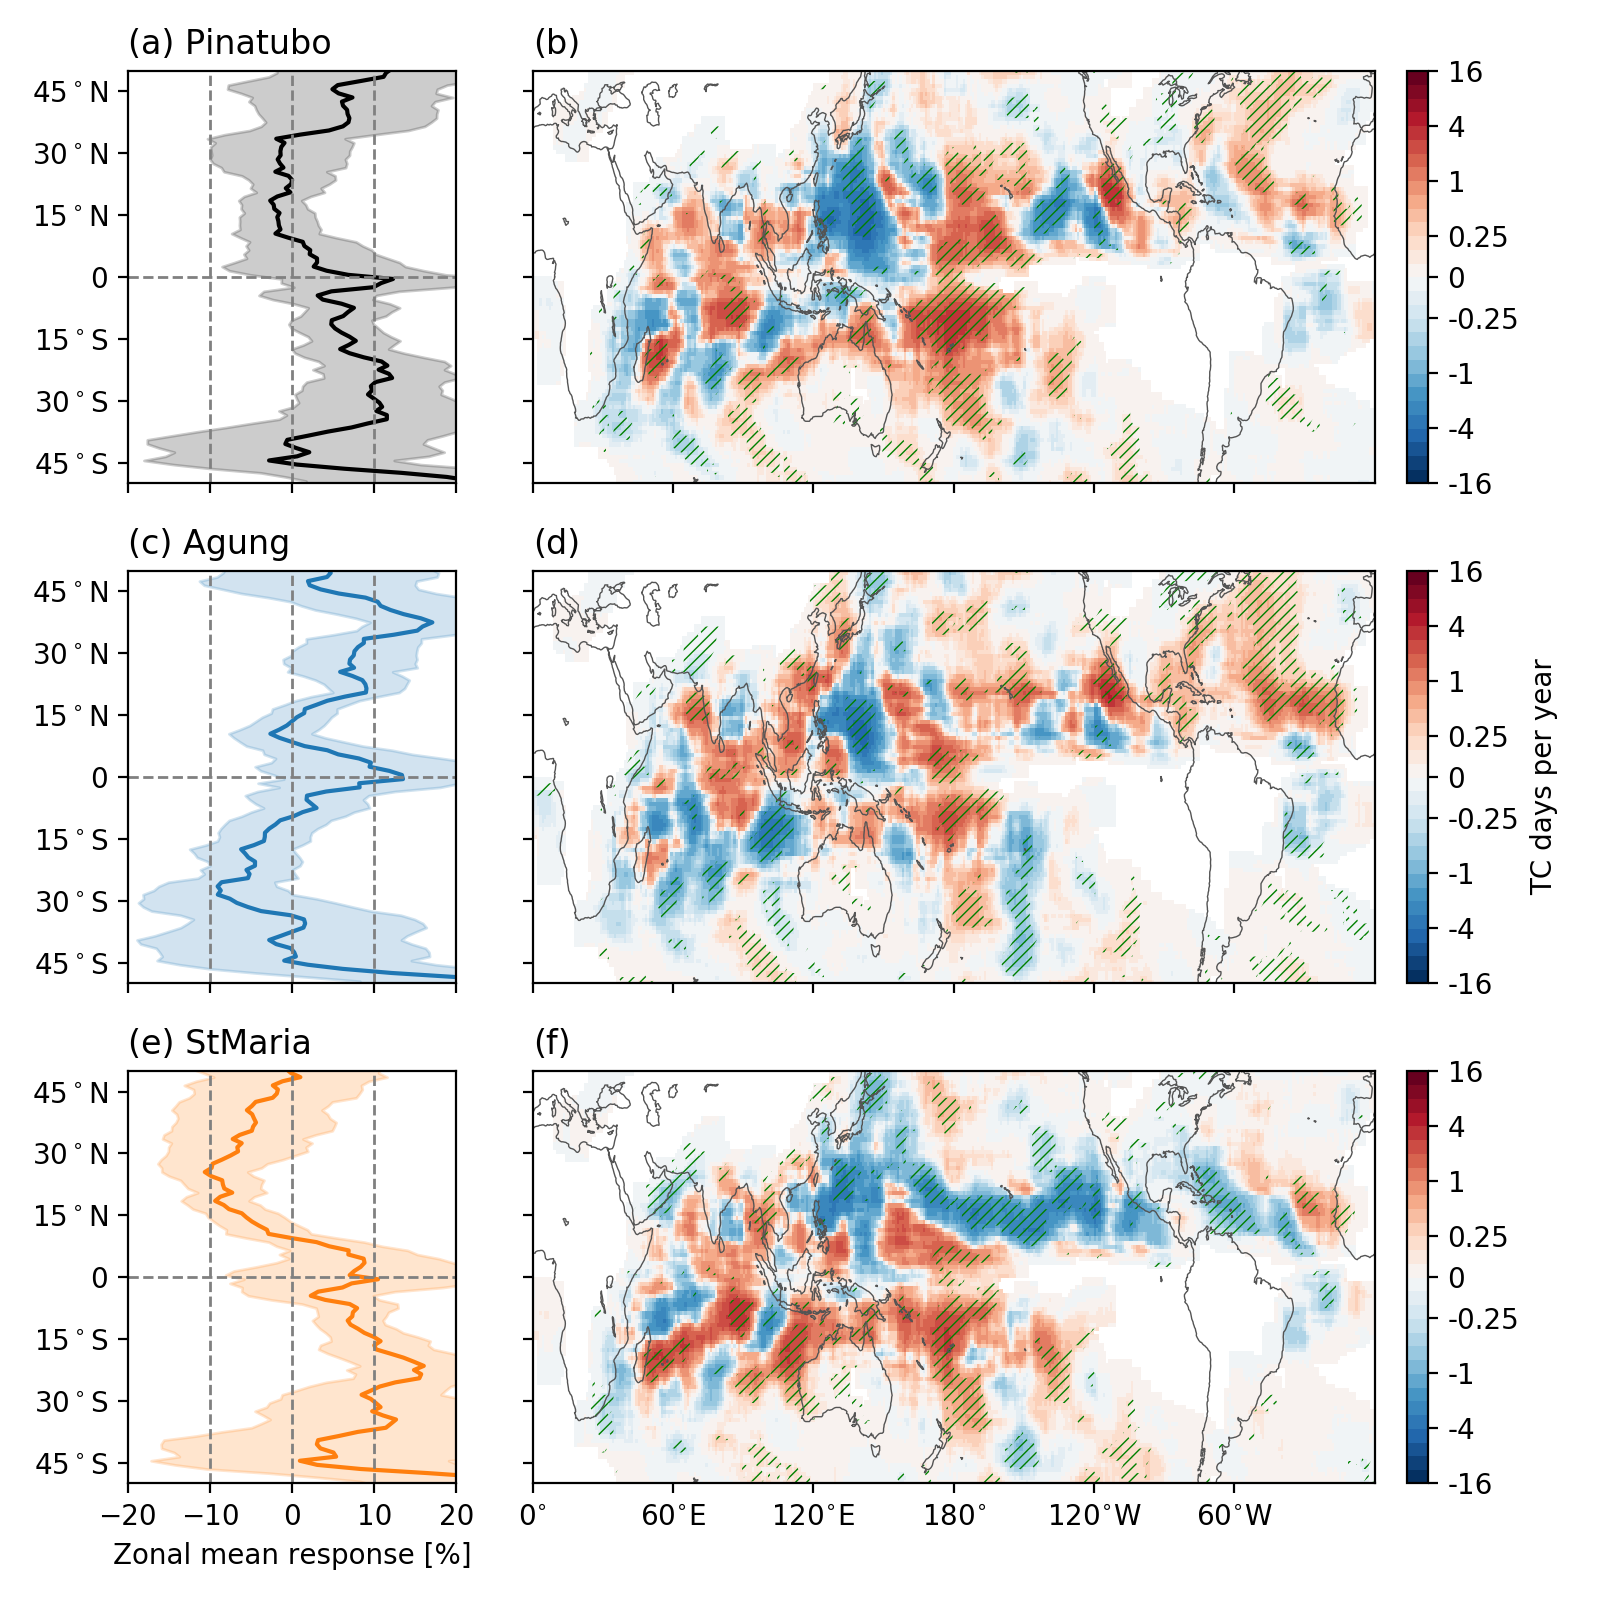

In [84]:
# fig revision_1 spread 3x2 subplots relative
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 2**np.arange(-3, 4.1, 0.5)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = (-16, -4, -1, -0.25, 0, 0.25, 1, 4, 16)
cbar_format = '%.2g'
alpha=0.2
hatches = ['//////']

ax = axes[0, 0]
volc_name, tag, mon_start = 'Pinatubo', 'Pinatubo', 6
color = 'k'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)/ctl_zmean*100
ts = ts.mean('en')/ctl_zmean*100
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color=color, alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
ax.axvline(-10, color='gray', lw=1, ls='--')
ax.axvline(10, color='gray', lw=1, ls='--')


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag, mon_start = 'Agung', 'Agung', 3
color = 'C0'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)/ctl_zmean*100
ts = ts.mean('en')/ctl_zmean*100
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
ax.axvline(-10, color='gray', lw=1, ls='--')
ax.axvline(10, color='gray', lw=1, ls='--')

ax = axes[2, 0]
volc_name, tag, mon_start = 'StMaria', 'StMaria', 10
color = 'C1'
ts = dvs[volc_name].pipe(lambda x: x-ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .mean('lon')
spread = p2t(0.05, df=ts.en.size-1) * ts.std('en') * ts.en.size**(-1/2)/ctl_zmean*100
ts = ts.mean('en')/ctl_zmean*100
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C1', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('Zonal mean response [%]')
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
ax.set_xlim(-20,20)
ax.axvline(-10, color='gray', lw=1, ls='--')
ax.axvline(10, color='gray', lw=1, ls='--')


ax = axes[0, 1]
volc_name, mon_start = 'Pinatubo', 6
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')
# expand_ax(ax)

ax = axes[1, 1]
volc_name, mon_start = 'Agung', 3
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).rename('TC days per year').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')
# expand_ax(ax)



ax = axes[2, 1]
plt.sca(ax)
volc_name, mon_start = 'StMaria', 10
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1 + n_years*12)).mean('time').pipe(lambda x: x*12/4) \
    .rolling(lon=10, center=True, min_periods=1).sum() \
    .rolling(lat=10, center=True, min_periods=1).sum()
spread = p2t(0.05, df=da.en.size-1) * da.std('en') * da.en.size**(-1/2)
da = da.mean('en')
sigmask = np.abs(da) > spread
bothmask = sigmask & tcmask
da.where(tcmask).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks, 'format': cbar_format}, rasterized=True)
da.where(bothmask).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45$^\circ$S', '30$^\circ$S', '15$^\circ$S', '0', '15$^\circ$N', '30$^\circ$N', '45$^\circ$N'])
plt.title('(f)', loc='left')



plt.tight_layout()
for ax in axes[:, 0]:
    axscale(ax, right=-0.5)
for ax in axes[:, 1]:
    axscale(ax, left=0.6)
axes[2,0].set_xticks(np.arange(-20,21,10))

figname = 'figs/fig_tc_percent.pdf'
plt.savefig(figname)

### Basin-mean TC resopnses

In [11]:
# cal tc basin mean
n_years = 4
time_new = np.arange(1, n_years+1)
dass = []
spreadss = []
volcs = ['Pinatubo', 'Agung', 'StMaria']
mon_starts = [6, 3, 10]
mon_names = ['JUN', 'MAR', 'OCT']
name = 'TCBasins'
names = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian',
        'South Indian', 'Australia', 'South Pacific', 'South Atlantic']
abbrevs = ['NA', 'EP', 'WP', 'NI',
          'SI', 'AU', 'SP', 'SA']
lat1 = 40
outlines = [( (295, 0), (260, 20), (260, lat1), (360, lat1), (360, 0) ),
            ( (200, 0), (200, lat1), (260, lat1), (260, 20), (295, 0) ),  
            ( (105, 0), (105, lat1), (200, lat1), (200, 0) ),
            ( (30, 0), (30, lat1), (105, lat1), (105, 0) ),
            ( (30, 0), (30, -lat1), (105, -lat1), (105, 0) ),
            ( (105,0), (105, -lat1), (165, -lat1), (165, 0) ),
            ( (165, 0), (165, -lat1), (290, -lat1), (290, 0) ),
            ( (290, 0), (290, -lat1), (360, -lat1), (360, 0) ),
           ]
numbers = np.arange(len(names))
basins = regionmask.Regions_cls(name=name, numbers=numbers, names=names, abbrevs=abbrevs, outlines=outlines)
bnumbers = basins.numbers
lat, lon = ctl_ens.lat, ctl_ens.lon
basinmasks = basins.mask(lon, lat)
for volc,mon,mon_name in zip(volcs, mon_starts, mon_names):
    print(volc, mon, mon_name)
    das = []
    spreads = []
    for bnumber in bnumbers:
        print(basins.abbrevs[bnumber], end='; ')
        da = dvs[volc].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
            .isel(time=slice(mon-1, mon-1+n_years*12)) \
            .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
            .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat']) \
            .assign_coords(time=time_new)
#         if bnumber == 1:
#             print(da.mean('en'), end='; ')
        ctl_bmean = ctl_ens.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
            .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat'])
#         if bnumber == 1:
#             print(ctl_bmean.data)
        spread = p2t(0.05, da.en.size-1) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
        da = da.mean('en')/ctl_bmean*100
        das.append(da)
        spreads.append(spread)
    print()
    das = xr.concat(das, dim=pd.Index(abbrevs, name='s'))
    spreads = xr.concat(spreads, dim=pd.Index(abbrevs, name='s'))
    
    dass.append(das)
    spreadss.append(spreads)
dass = xr.concat(dass, pd.Index(volcs, name='volc'))
spreadss = xr.concat(spreadss, pd.Index(volcs, name='volc'))

Pinatubo 6 JUN
NA; EP; WP; NI; SI; AU; SP; SA; 
Agung 3 MAR
NA; EP; WP; NI; SI; AU; SP; SA; 
StMaria 10 OCT
NA; EP; WP; NI; SI; AU; SP; SA; 


<IPython.core.display.Javascript object>


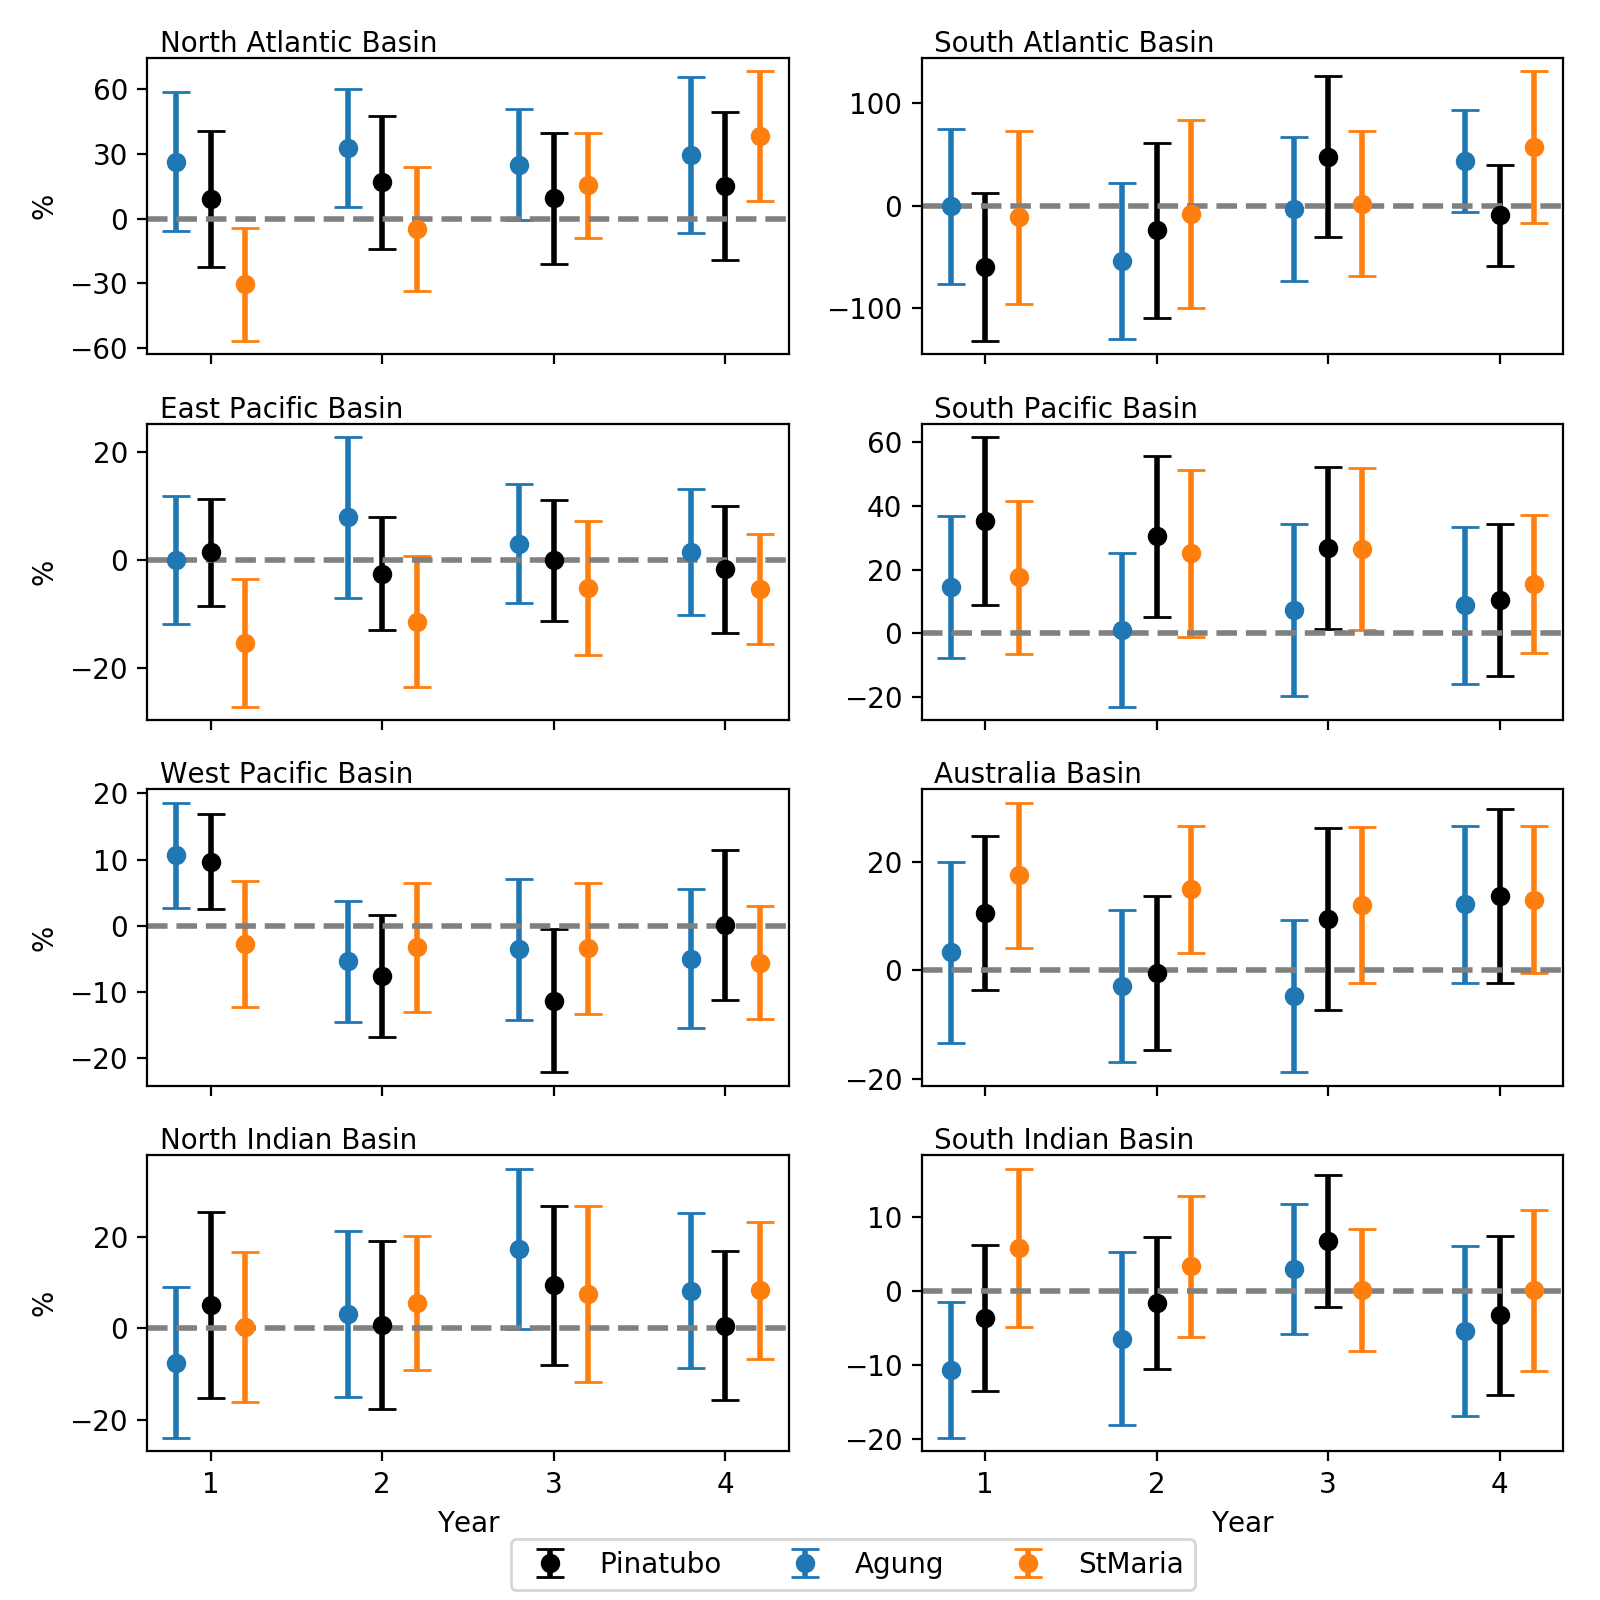

In [85]:
# fig tc basin mean
fig, axes = plt.subplots(4, 2, sharex=True, sharey=False, figsize=(8,8))
csize = 5 #capsize 
fmt = 'o'
year = 1


def tc_errorbar(ax=None, bnumber=0):
    if ax is None:
        ax = plt.gca()
    plt.sca(ax)
    s = basins.abbrevs[bnumber]
    
    da = dass.sel(s=s)
    spread = spreadss.sel(s=s)
    
    volc = 'Pinatubo'
#     color = 'C2'
    color = 'k'
    da.sel(volc=volc) \
        .pipe((plt.errorbar, 'y'), 
              x=da.time,
              yerr=spread.sel(volc=volc), 
              capsize=csize, label=volc, color=color, fmt=fmt)

    volc = 'Agung'
    color = 'C0'
    da.sel(volc=volc) \
        .pipe((plt.errorbar, 'y'), 
              x=da.time-0.2,
              yerr=spread.sel(volc=volc), 
              capsize=csize, label=volc, color=color, fmt=fmt)

    volc = 'StMaria'
    color = 'C1'
    da.sel(volc=volc) \
        .pipe((plt.errorbar, 'y'), 
              x=da.time+0.2,
              yerr=spread.sel(volc=volc), 
              capsize=csize, label=volc, color=color, fmt=fmt)
    ax.axhline(0, ls='--', color='gray')
    ax.text(0.02, 1.0, basins.names[bnumber]+' Basin', transform=ax.transAxes, ha='left', va='bottom')
#     ax.set_ylabel('%')


for i,ax in enumerate(axes[:, 0]):
    tc_errorbar(ax=ax, bnumber=i)
    ax.set_ylabel('%')
#     if i==0:
#         ax.legend(ncol=3, bbox_to_anchor=(1, 1.5), loc='upper center')
ax.set_xlabel('Year')
for i,ax in enumerate(axes[:, 1]):
    tc_errorbar(ax=ax, bnumber=7-i)
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1,5))
# ax.set_ylim(-70, 70)

axes[0,0].set_yticks(np.arange(-60,61,30))
plt.tight_layout(rect=(0,0.02,1,1))
axes[3,0].legend(ncol=3, bbox_to_anchor=(1.1, -0.25), loc='upper center', frameon=True)
figname = 'figs/fig_tc_basinMean.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


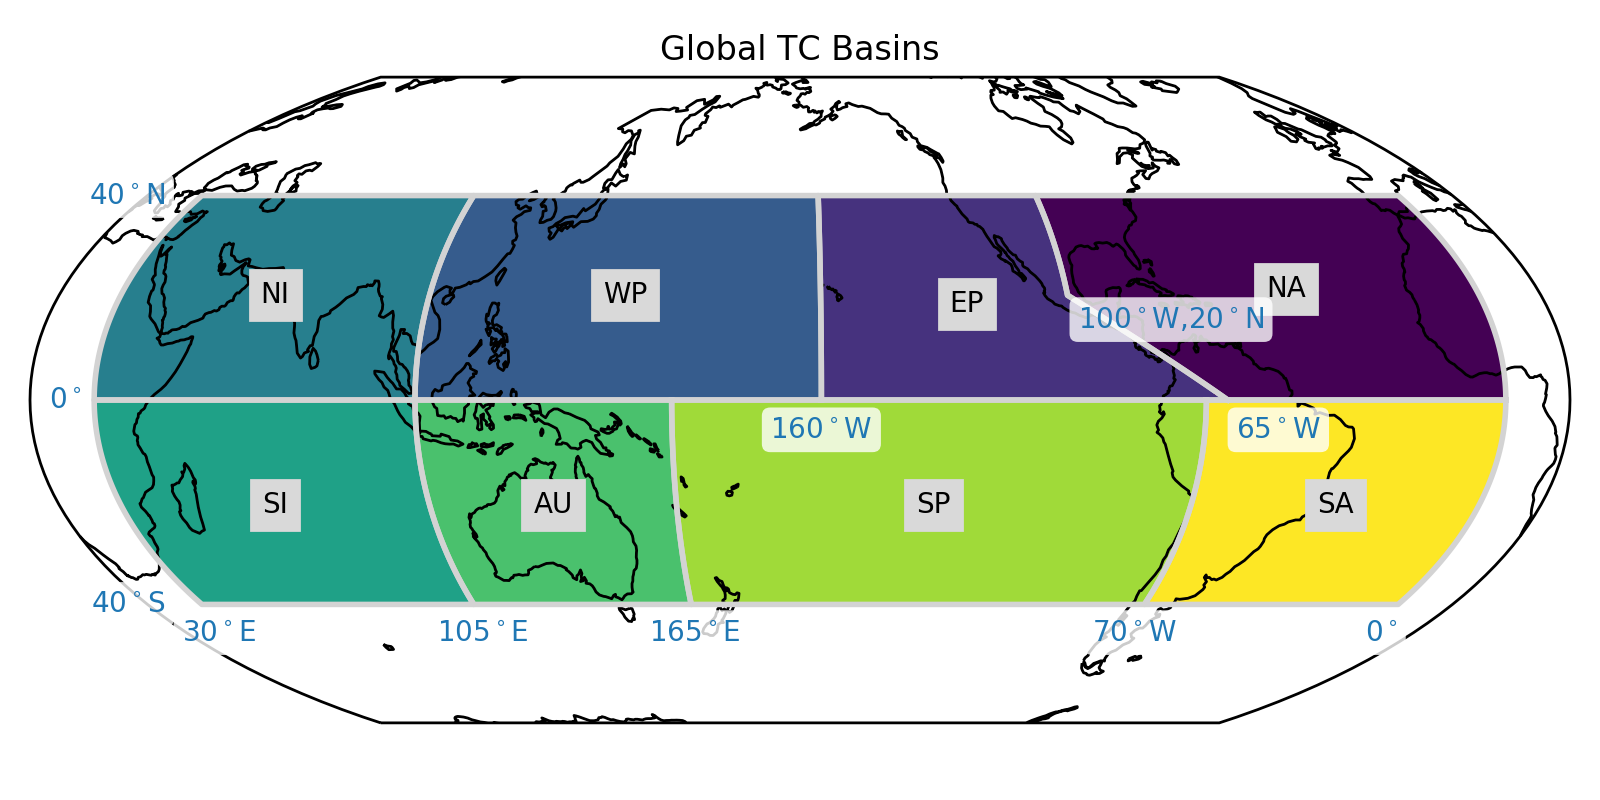

In [18]:
# fig basins
plt.figure(figsize=(8,4))
dproj = ccrs.PlateCarree()
bbox = {'facecolor': 'w', 'alpha':.8, 'boxstyle': 'round', 'edgecolor': 'none'}
tcolor = 'C0'
p = basinmasks.geo.cartoplot(proj='moll', 
                             proj_kws={'central_longitude': 195}, 
                             rasterized=True,
                             add_colorbar=False)
ax = p.axes
basins.plot(ax=ax, label='abbrev',
            add_ocean=False, line_kws={'color': 'lightgray'})
# ax.set_global()

ax.text(30-3, 0, '0$^\circ$', transform=dproj, ha='right', va='center', bbox=bbox, color=tcolor)
ax.text(30-10, 40, '40$^\circ$N', transform=dproj, ha='right', va='center', bbox=bbox, color=tcolor)
ax.text(30-10, -40, '40$^\circ$S', transform=dproj, ha='right', va='center', bbox=bbox, color=tcolor)
ax.text(30, -40-3, '30$^\circ$E', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(105, -40-3, '105$^\circ$E', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(165, -40-3, '165$^\circ$E', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(200, 0-3, f'{360-200}$^\circ$W', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(290, -40-3, f'{360-290}$^\circ$W', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(295+2, 0-3, f'{360-295}$^\circ$W', transform=dproj, ha='left', va='top', bbox=bbox, color=tcolor)
ax.text(360, -40-3, '0$^\circ$', transform=dproj, ha='center', va='top', bbox=bbox, color=tcolor)
ax.text(260+2, 20-2, f'{360-260}$^\circ$W,20$^\circ$N', transform=dproj, ha='left', va='top', bbox=bbox, color=tcolor)

ax.set_title('Global TC Basins')
plt.tight_layout()

figname = 'figs/fig_tc_basins.pdf'
plt.savefig(figname)

## test

<IPython.core.display.Javascript object>


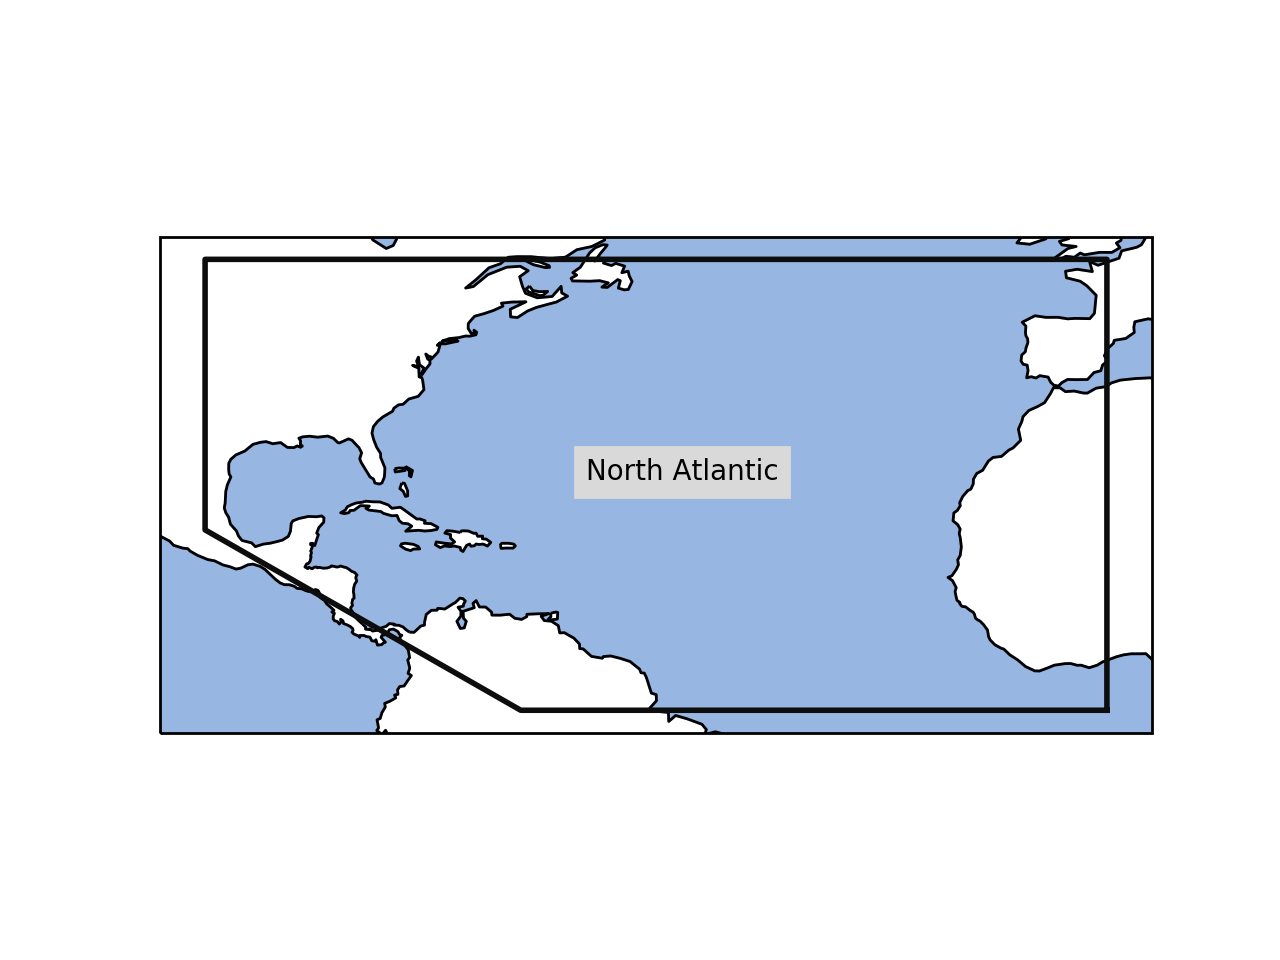

In [177]:
path = [(295, 0), (260, 20), (260, 50), (360, 50), (360, 0)]
region = regionmask.Regions_cls('NAtl', [0], ['North Atlantic'], ['NAtl'], [path])
region.plot(label='name')

<IPython.core.display.Javascript object>


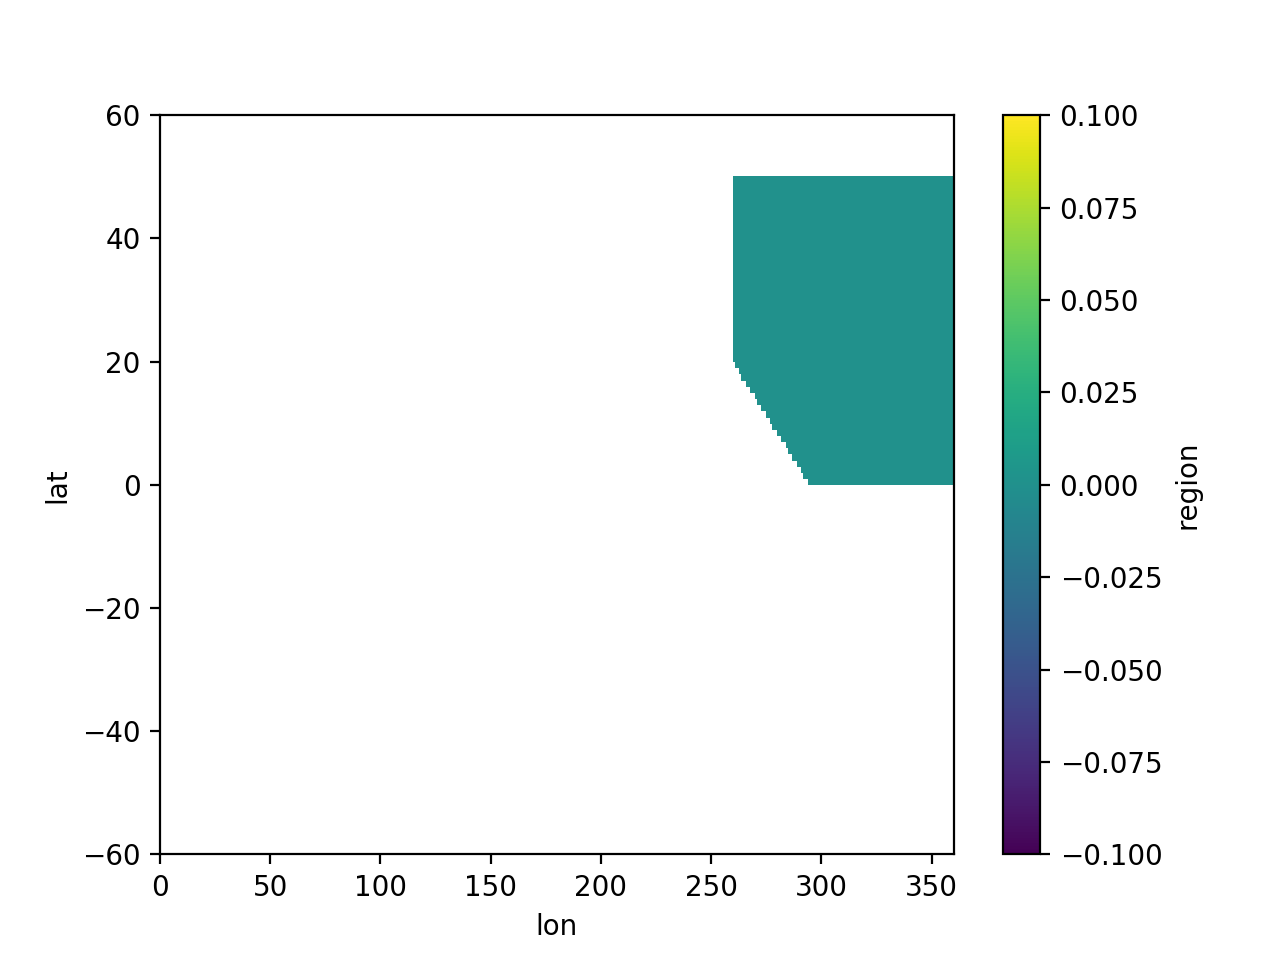

In [99]:
grids = region.mask(da.lon, da.lat)

grids.plot()

In [172]:
# N Atlantic mask
bname, blongname = 'NAtl', 'North Atlantic'
path = [(295, 0), (260, 20), (260, 50), (360, 50), (360, 0)]
region = regionmask.Regions_cls(bname, [0], [blongname], [bname], [path])
basinmask = region.mask(ctl_ens.lon, ctl_ens.lat)

<IPython.core.display.Javascript object>


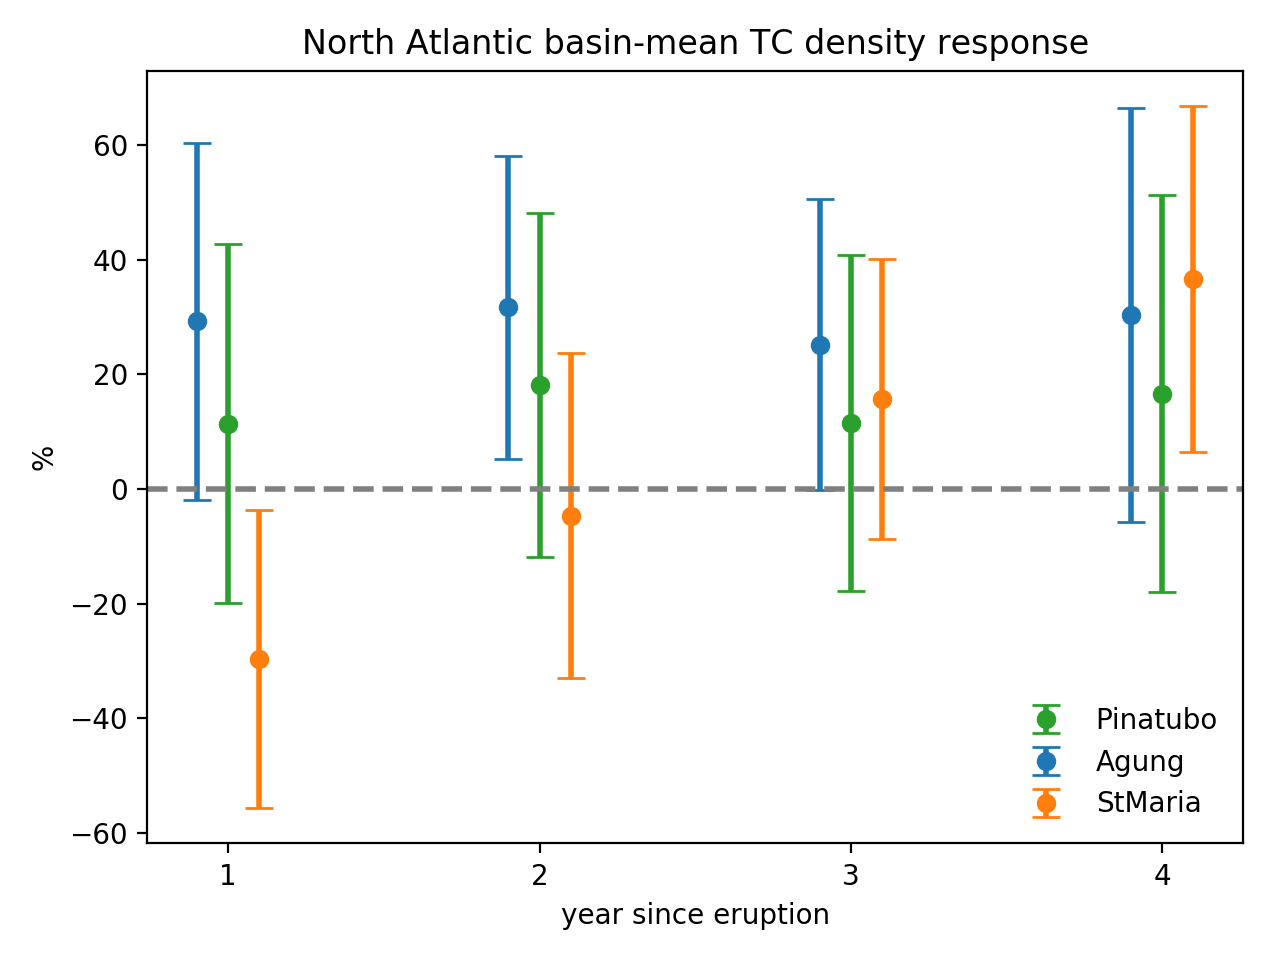

In [175]:
# fig errorbar NAtl
fig, ax = plt.subplots()
ctl_bmean = ctl_ens.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lowpass_tc).where(basin==0).mean(['lon', 'lat'])
n_years = 4
time_new = np.arange(1, n_years+1)
csize = 5 #capsize 
fmt = 'o'

volc_name, mon_start, mon_name = 'Pinatubo', 6, 'JUN'
color = 'C2'
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
    .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lowpass_tc).where(basinmask==0).mean(['lon', 'lat']) \
    .assign_coords(time=time_new)
spread = p2t(0.05, da.en.size-1) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
da = da.mean('en')/ctl_bmean*100
da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

volc_name, mon_start, mon_name = 'Agung', 3, 'MAR'
color = 'C0'
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
    .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lowpass_tc).where(basinmask==0).mean(['lon', 'lat']) \
    .assign_coords(time=time_new-0.1)
spread = p2t(0.05, da.en.size-1) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
da = da.mean('en')/ctl_bmean*100
da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

volc_name, mon_start, mon_name = 'StMaria', 10, 'OCT'
color = 'C1'
da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
    .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
    .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lowpass_tc).where(basinmask==0).mean(['lon', 'lat']) \
    .assign_coords(time=time_new+0.1)
spread = p2t(0.05, da.en.size) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
da = da.mean('en')/ctl_bmean*100
da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

ax.legend()
ax.set_ylabel('%')
ax.set_xlabel('year since eruption')
ax.set_xticks(time_new)
ax.axhline(0, color='gray', ls='--')
ax.set_title(f'{blongname} basin-mean TC density response')
ax.autoscale()

plt.tight_layout()

<IPython.core.display.Javascript object>


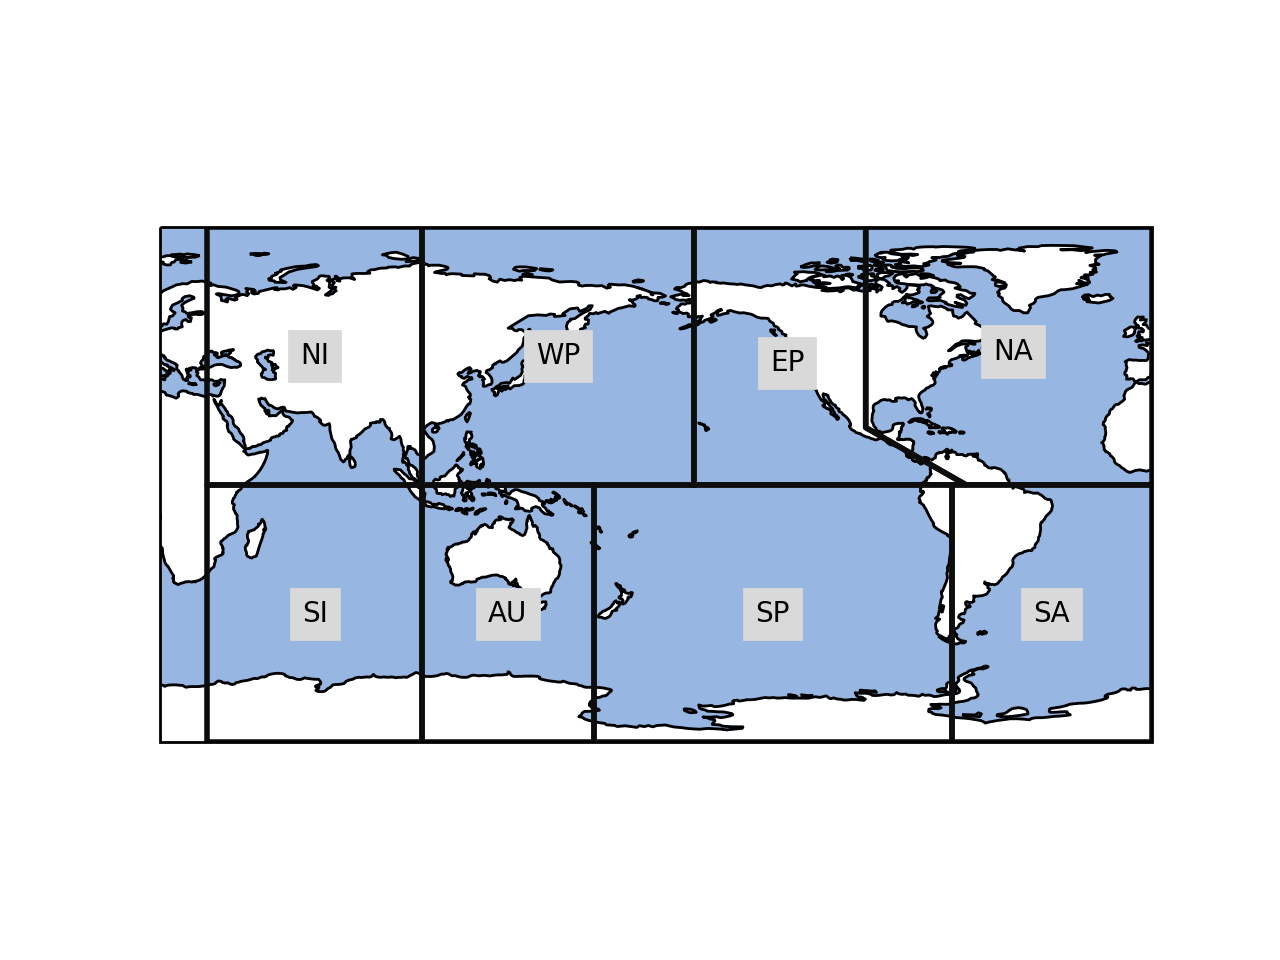

In [181]:
name = 'TCBasins'
names = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian',
        'South Indian', 'Australia', 'South Pacific', 'South Atlantic']
abbrevs = ['NA', 'EP', 'WP', 'NI',
          'SI', 'AU', 'SP', 'SA']
outlines = [( (295, 0), (260, 20), (260, 90), (360, 90), (360, 0) ),
            ( (200, 0) ), (200,90), (260,90), (260,20), (295, 0),   
            ( (105, 0), (105, 90), (200, 90), (200, 0) ),
            ( (30, 0), (30, 90), (105, 90), (105, 0) ),
            ( (30, 0), (30, -90), (105, -90), (105, 0) ),
            ( (105,0), (105, -90), (165, -90), (165, 0) ),
            ( (165, 0), (165, -90), (290, -90), (290, 0) ),
            
            ( (290, 0), (290, -90), (360, -90), (360, 0) ),
           ]
numbers = np.arange(len(names))
basins = regionmask.Regions_cls(name=name, numbers=numbers, names=names, abbrevs=abbrevs, outlines=outlines)

basins.plot(label='abbrev', proj=ccrs.PlateCarree(central_longitude=180))

<IPython.core.display.Javascript object>


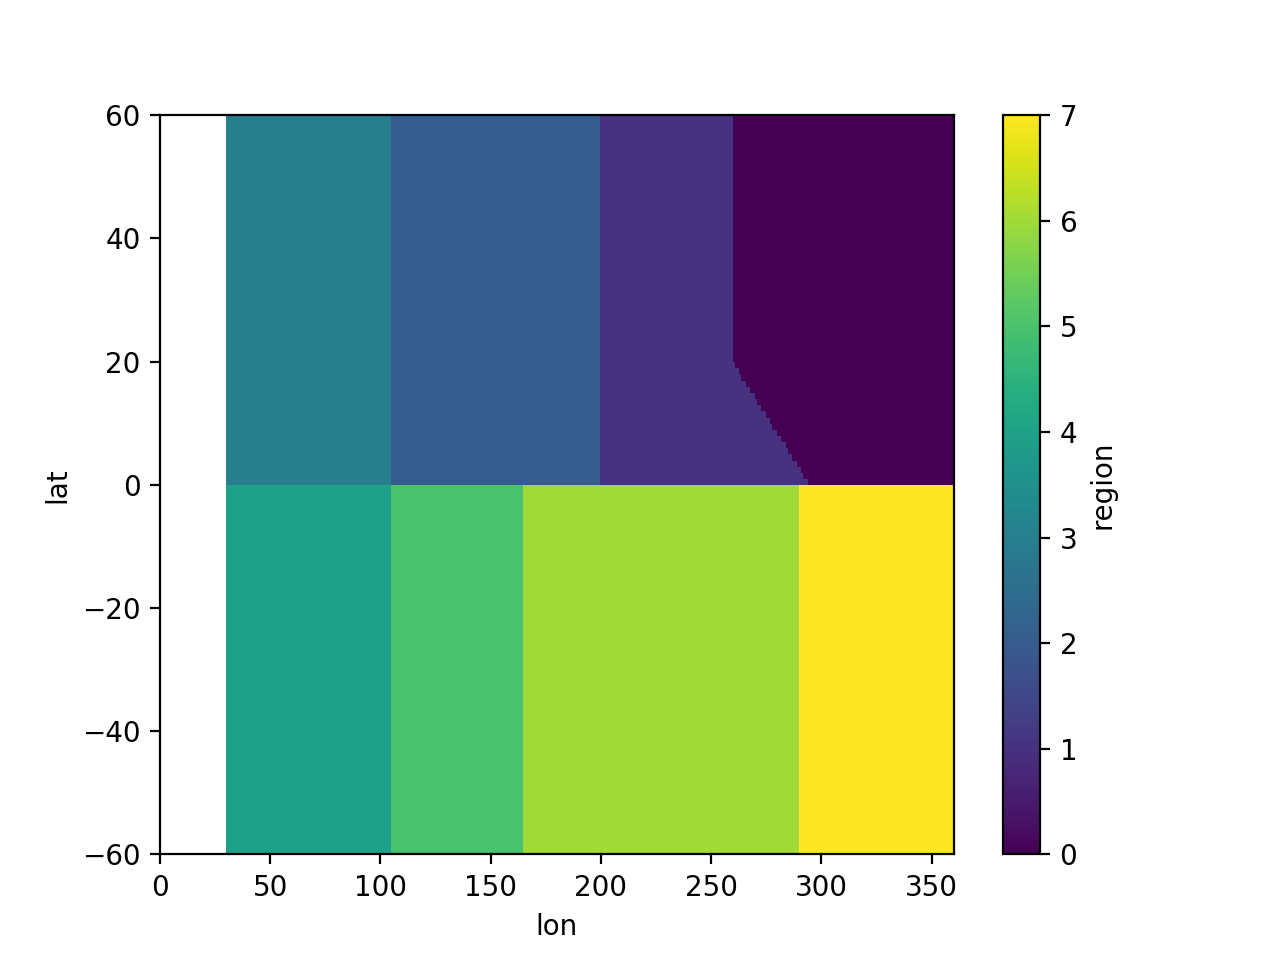

In [185]:
basinmasks = basins.mask(ctl_ens.lon, ctl_ens.lat)

basinmasks.plot()

In [187]:
basins.numbers

[0, 1, 2, 3, 4, 5, 6, 7]

<IPython.core.display.Javascript object>


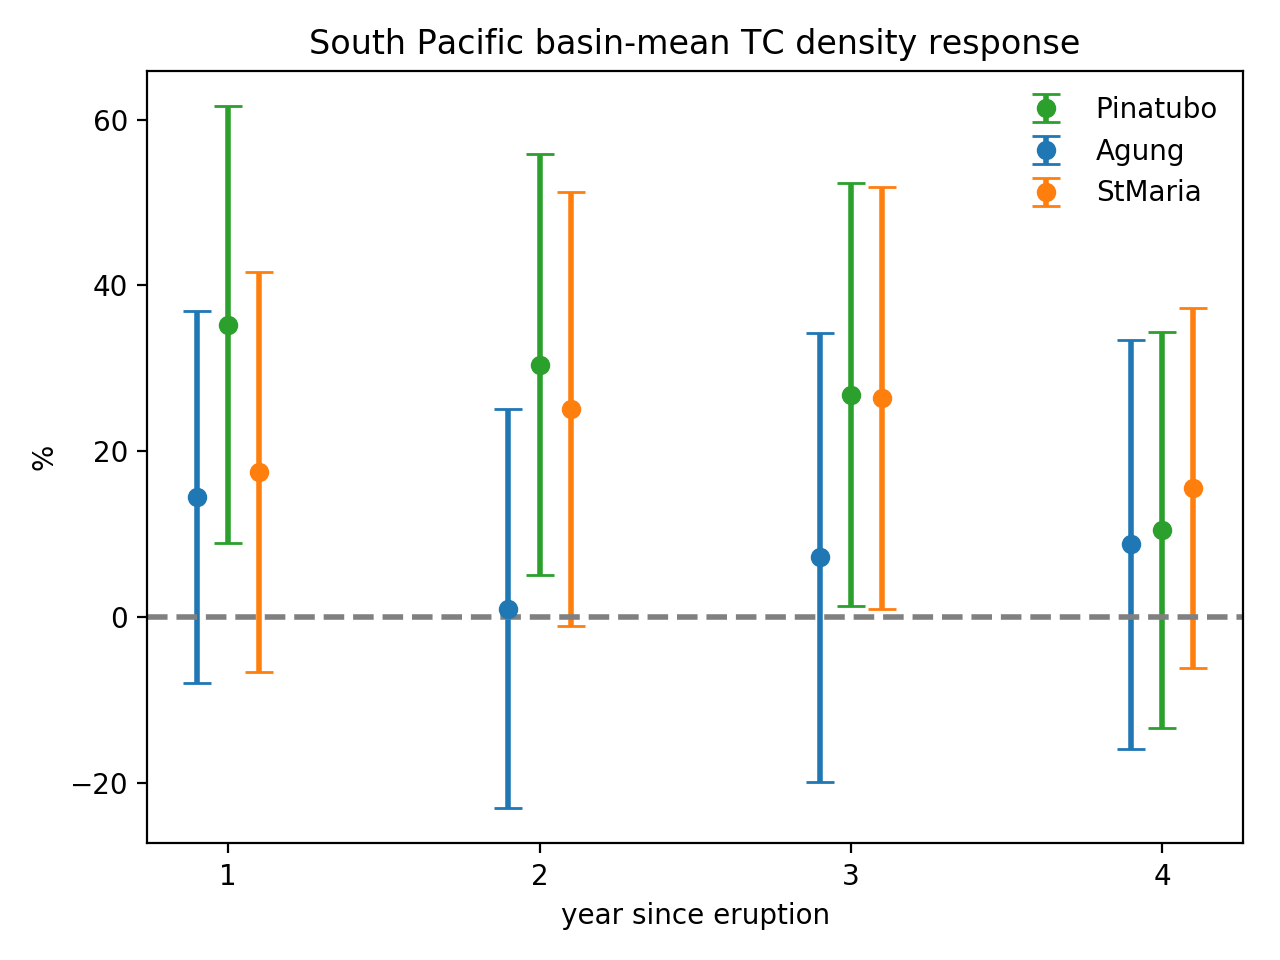

In [218]:
# fig errorbar NAtl
fig, ax = plt.subplots()

lon, lat = ctl_ens.lon, ctl_ens.lat
n_years = 4
time_new = np.arange(1, n_years+1)
csize = 5 #capsize 
fmt = 'o'
lat1 = 40

def tc_errorbar(ax=None, bnumber=0):
    '''plot errorbar of TC density over a specified basin'''
    if ax is None:
        ax = plt.gca()
#     bnumber = 0
    bname = basins.names[bnumber]
    ctl_bmean = ctl_ens.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
        .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat'])


    volc_name, mon_start, mon_name = 'Pinatubo', 6, 'JUN'
    color = 'C2'
    da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
        .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
        .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
        .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat']) \
        .assign_coords(time=time_new)
    spread = p2t(0.05, da.en.size-1) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
    da = da.mean('en')/ctl_bmean*100
    da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

    volc_name, mon_start, mon_name = 'Agung', 3, 'MAR'
    color = 'C0'
    da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
        .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
        .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
        .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat']) \
        .assign_coords(time=time_new-0.1)
    spread = p2t(0.05, da.en.size-1) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
    da = da.mean('en')/ctl_bmean*100
    da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

    volc_name, mon_start, mon_name = 'StMaria', 10, 'OCT'
    color = 'C1'
    da = dvs[volc_name].pipe(lambda x: x - ctl_ens.assign_coords(time=x.time)) \
        .isel(time=slice(mon_start-1, mon_start-1+n_years*12)) \
        .resample(time=f'AS-{mon_name}').mean('time').pipe(lambda x: x*12/4) \
        .pipe(lowpass_tc).where(basinmasks==bnumber).where(np.abs(lat)<lat1).mean(['lon', 'lat']) \
        .assign_coords(time=time_new+0.1)
    spread = p2t(0.05, da.en.size) * da.std('en') * da.en.size**(-1/2) /ctl_bmean*100
    da = da.mean('en')/ctl_bmean*100
    da.pipe((plt.errorbar, 'y'), x=da.time, yerr=spread, capsize=csize, label=volc_name, color=color, fmt=fmt)

    ax.set_ylabel('%')
    ax.set_xlabel('year since eruption')
    ax.set_xticks(time_new)
    ax.axhline(0, color='gray', ls='--')
    ax.set_title(f'{bname} basin-mean TC density response')
    ax.autoscale()
tc_errorbar(ax=ax, bnumber=6)
    
ax.legend()
plt.tight_layout()

## foot

<IPython.core.display.Javascript object>


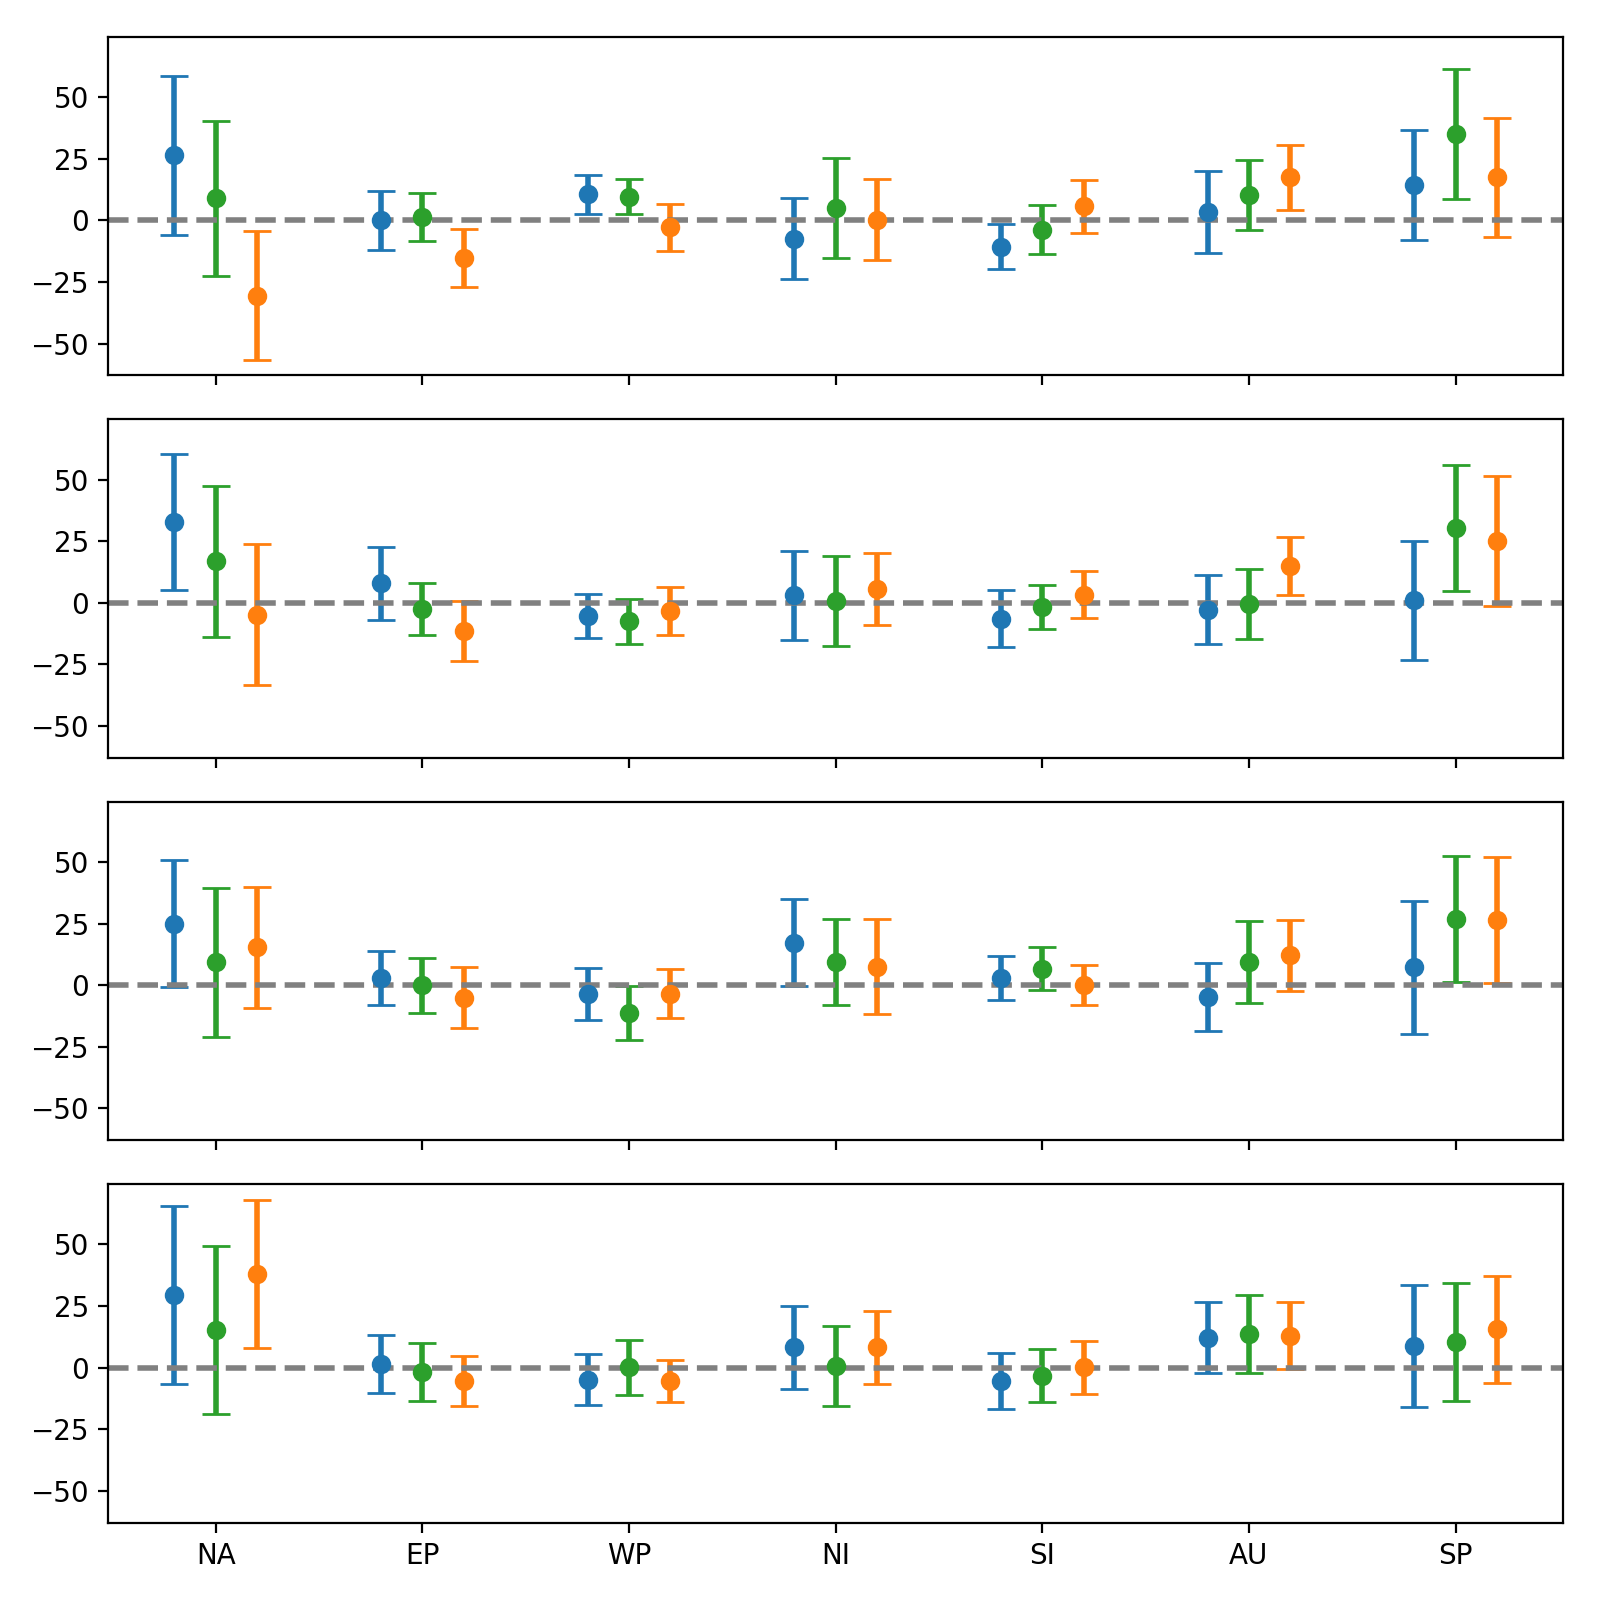

In [311]:
# fig tc basin mean old
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(8,8))
csize = 5 #capsize 
fmt = 'o'
year = 1


def tc_errorbar(ax=None, year=1):
    if ax is None:
        ax = plt.gca()
    plt.sca(ax)
    
    da = dass.sel(time=year).isel(s=slice(0,-1))
    spread = spreadss.sel(time=year).isel(s=slice(0,-1))
    bnumbers = basins.numbers[0:-1]
    
    volc = 'Pinatubo'
    color = 'C2'
    da.sel(volc=volc).assign_coords(s=bnumbers) \
        .pipe((plt.errorbar, 'y'), 
              x=bnumbers,
              yerr=spread.sel(volc=volc).assign_coords(s=bnumbers), 
              capsize=csize, label=volc, color=color, fmt=fmt)

    volc = 'Agung'
    color = 'C0'
    da.sel(volc=volc).assign_coords(s=bnumbers) \
        .pipe((plt.errorbar, 'y'), 
              x=np.array(bnumbers)-0.2,
              yerr=spread.sel(volc=volc).assign_coords(s=bnumbers), 
              capsize=csize, label=volc, color=color, fmt=fmt)

    volc = 'StMaria'
    color = 'C1'
    da.sel(volc=volc).assign_coords(s=bnumbers) \
        .pipe((plt.errorbar, 'y'), 
              x=np.array(bnumbers)+0.2,
              yerr=spread.sel(volc=volc).assign_coords(s=bnumbers), 
              capsize=csize, label=volc, color=color, fmt=fmt)
    ax.axhline(0, ls='--', color='gray')
    ax.set_xticks(bnumbers)

ax = axes[0]
tc_errorbar(ax=ax, year=1)
ax = axes[1]
tc_errorbar(ax=ax, year=2)
ax = axes[2]
tc_errorbar(ax=ax, year=3)
ax = axes[3]
tc_errorbar(ax=ax, year=4)



ax.set_xticklabels(basins.abbrevs[0:-1])

plt.tight_layout()

<IPython.core.display.Javascript object>


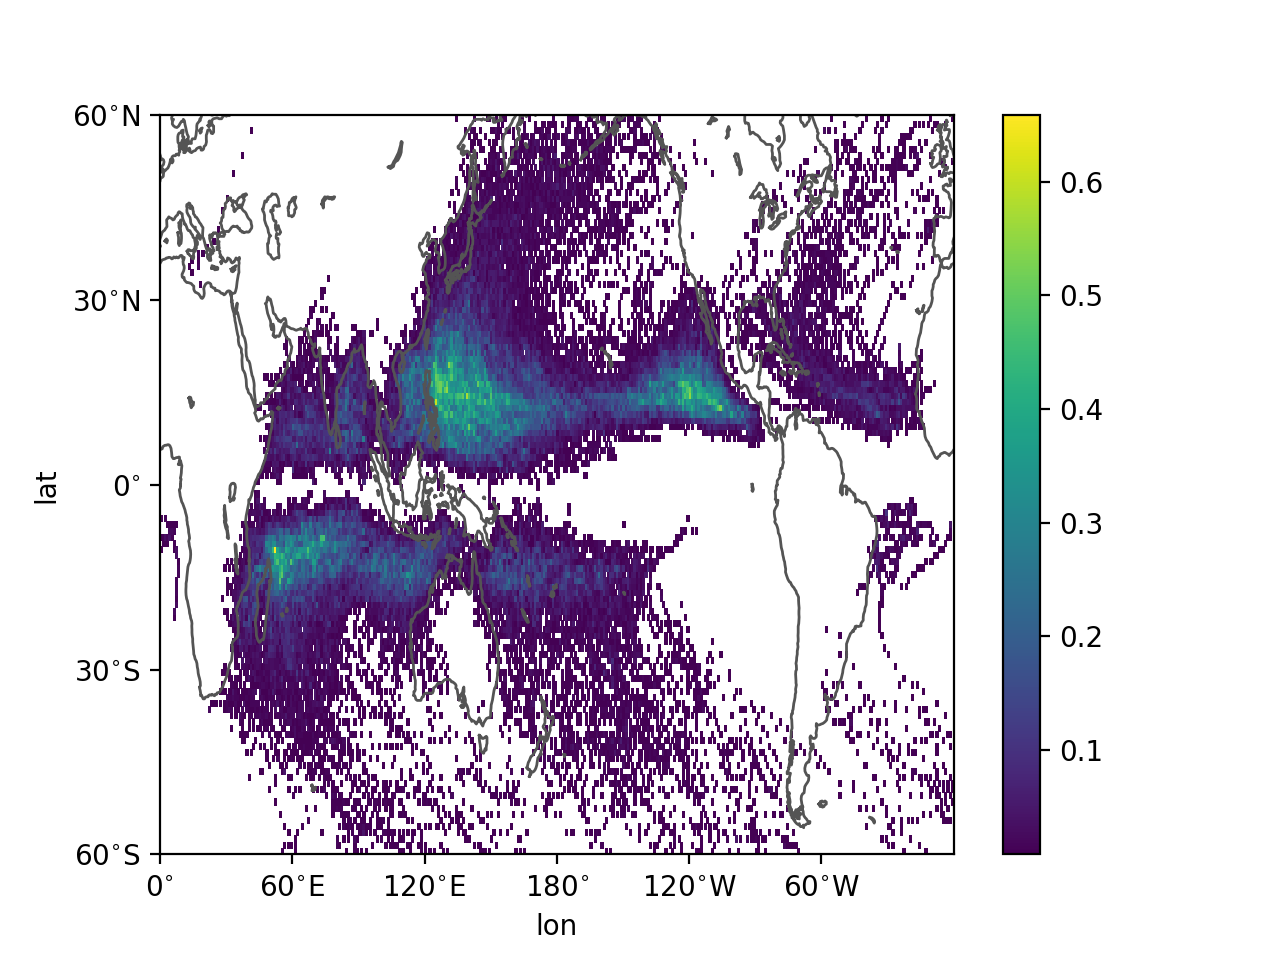

In [28]:
da = ctl_ens
da.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lambda x: x.where(x>0)).plot()
mapplot()

<IPython.core.display.Javascript object>


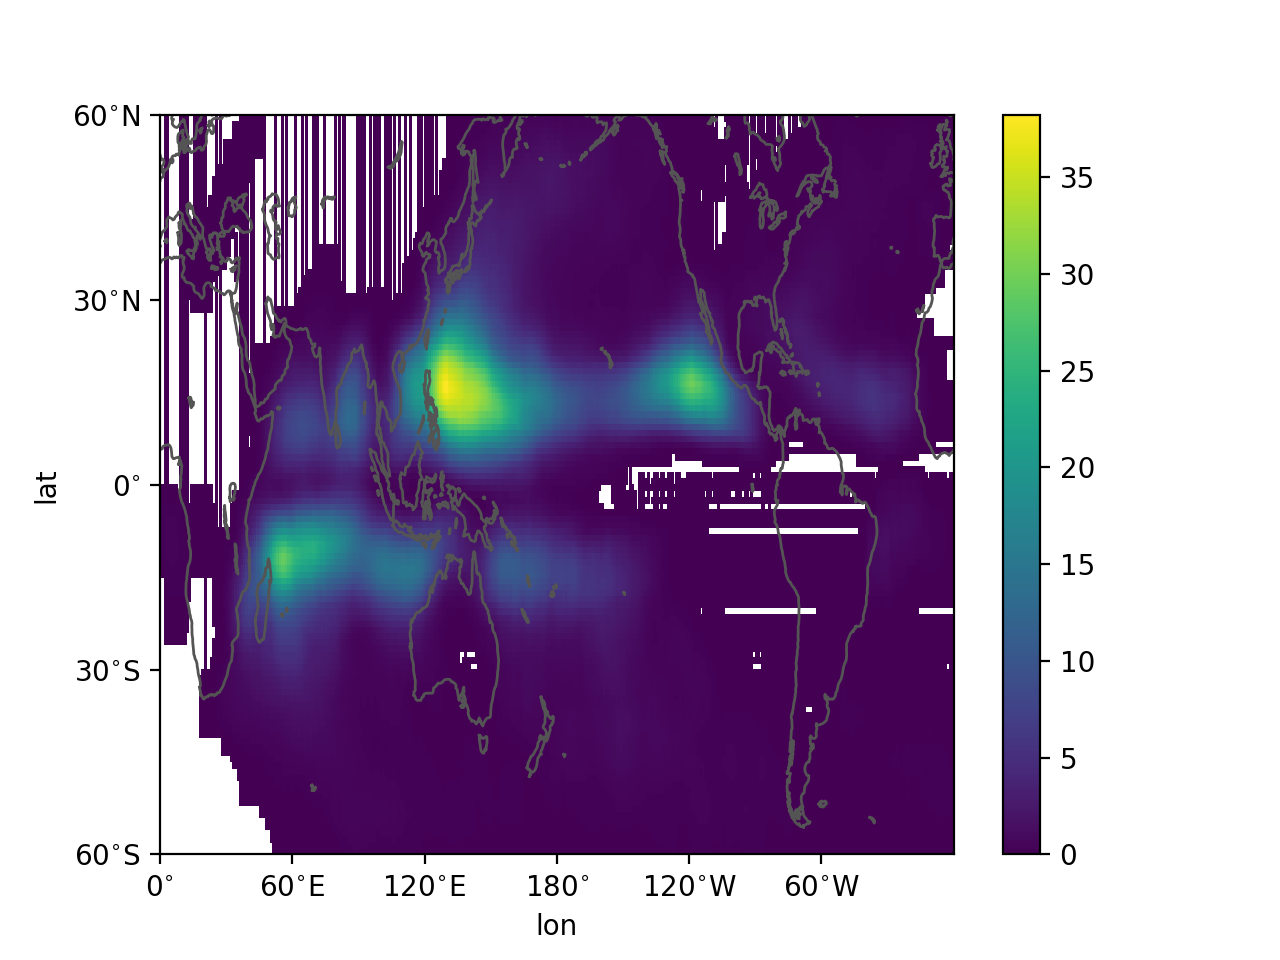

In [27]:
da = ctl_ens
da.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lowpass_tc).pipe(lambda x: x.where(x>0)).plot()
mapplot()

<IPython.core.display.Javascript object>


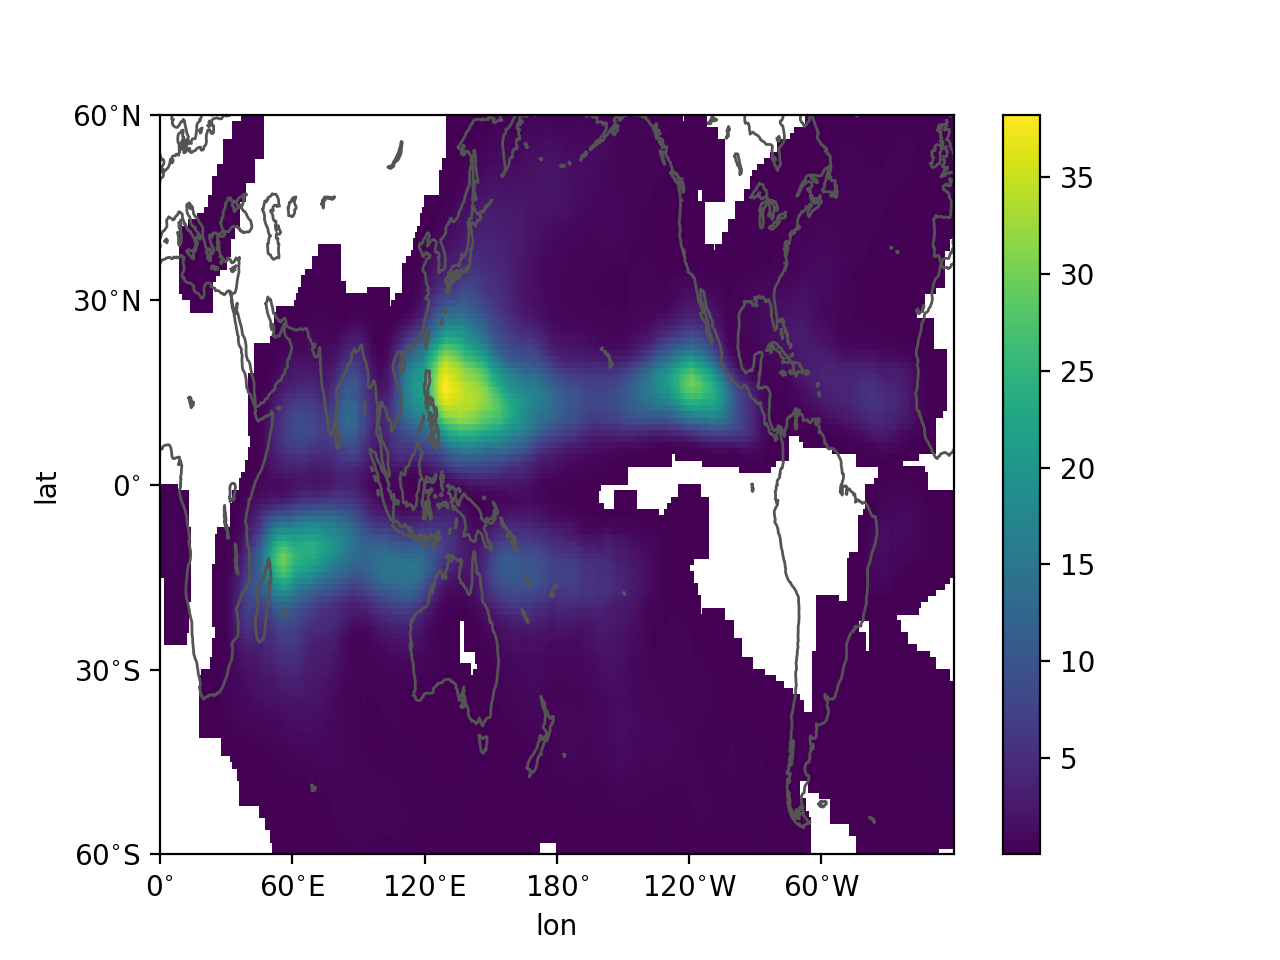

In [29]:
da = ctl_ens
da.sel(time='0001').mean('en').mean('time').pipe(lambda x: x*12/4) \
    .pipe(lambda x: x.where(x>0)).pipe(lowpass_tc).plot()
mapplot()

In [336]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js">
</script>